<a href="https://colab.research.google.com/github/MohamedGalal2/Multi_Cancer_Identification_and_Segmentation/blob/main/Multi_Cancer_Identification_and_Segmentation3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
import cv2
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import OneHotEncoder
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from keras import applications
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, MaxPool2D
from keras.optimizers import Adam
import numpy as np
!pip install segmentation_models 
from natsort import natsorted 
#from keras.layers.normalization import BatchNormalization
from keras.layers import *
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from PIL import Image, ImageEnhance

from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2
from google.colab.patches import cv2_imshow
import sys
import random
import warnings #
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tfD

import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle
from datetime import datetime as dt
import datetime
# from PIL import Image
# from PIL import ImageFilter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.5 MB/s 


In [ ]:
IMG_SIZE=224

In [ ]:
def binarize_mask(mask):
  mask=np.asarray(mask)
  mask = mask.astype("uint8")
  ret2,thresh1 = cv2.threshold(mask,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  return thresh1


In [ ]:
def encode(y):
  y_df=pd.DataFrame(y)
  enc=OneHotEncoder()
  enc_data=pd.DataFrame(enc.fit_transform(y_df).toarray())
  y=enc_data.astype(int)
  y=np.asarray(y)
  return y


In [ ]:
def enhance(imgarr):    ## not used; decreased the accuracy of the models
                        
    enhancer = ImageEnhance.Sharpness(imgarr.convert('RGB'))
    factor = 4
    imgarr = enhancer.enhance(factor)
    imgarr=np.asarray(imgarr)
    return imgarr
 

In [ ]:
def clahe(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

  #configure CLAHE
  clahe = cv2.createCLAHE(clipLimit=2,tileGridSize=(8,8))

  #0 to 'L' channel, 1 to 'a' channel, and 2 to 'b' channel
  img[:,:,0] = clahe.apply(img[:,:,0])

  img = cv2.cvtColor(img, cv2.COLOR_Lab2RGB)
  return img

# Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
def create_brain_data(Type):
    pa = "/content/gdrive/MyDrive/Dataset/Brain scans"
    x = []
    y_list=[]
    img_idx=0
    y_mask=[]
    ind=0

    for FolderName in sorted(os.listdir(pa)):  # brain scans

        y=int(FolderName=="Tumor")
          
        inputPath = os.path.join(pa, FolderName)
       
        for file in (sorted(os.listdir(inputPath))): 
            
            
            filePath = os.path.join(inputPath, file)
            if(file==Type or file==Type.upper()):
                for img in (sorted(os.listdir(filePath))):

                    imgPath = os.path.join(filePath, img)

                    imgarr=cv2.imread(imgPath)
                    imgarr = cv2.cvtColor(imgarr, cv2.COLOR_BGR2RGB)
                    imgarr = cv2.resize(imgarr, (IMG_SIZE,IMG_SIZE))
                    
                    
                    x.append(imgarr)
                    y_list.append([0,y])
                    y_mask.append([ind,y])
                    ind+=1        

    return x,y_list,y_mask
Xtrain_brain,Ytrain_brain,y_trainmask = create_brain_data('Train')
Xtest_brain,Ytest_brain,y_test_mask = create_brain_data('Test')

In [ ]:
def create_breast_data(Type):
    pa = "/content/gdrive/MyDrive/Dataset/Breast scans"
    x = []
    masks = []
    y_list=[]
    img_idx=0
    y=0
    normal = []
    benign = []
    malignant = []
    for FolderName in sorted(os.listdir(pa)):  # brain scans

        
    
        inputPath = os.path.join(pa, FolderName)
       
        for file in (sorted(os.listdir(inputPath))): 
            
            
            filePath = os.path.join(inputPath, file)
            if(file==Type or file==Type.upper()):
                for img in (natsorted(os.listdir(filePath))):

                    imgPath = os.path.join(filePath, img)
                    img_name=img.split('_')
                    img_name.append(0)
 
                    if(img_name[1] ==0):
                        imgarr=cv2.imread(imgPath)
                        imgarr = cv2.cvtColor(imgarr, cv2.COLOR_BGR2RGB)
                        imgarr = cv2.resize(imgarr, (IMG_SIZE,IMG_SIZE))
                        x.append(imgarr)
                        if(FolderName=="normal"):
                            y=0
                            normal.append(imgarr)
                        elif(FolderName=="benign"):
                            y=1
                            benign.append(imgarr)
                        else:
                            y=2
                            malignant.append(imgarr)
                        y_list.append([1,y])


    return x,y_list,normal,benign,malignant
Xtrain_breast,Ytrain_breast,normal_train,benign_train,malignant_train=create_breast_data('Train')
Xtest_breast,Ytest_breast,normal_test,benign_test,malignant_test=create_breast_data('Test')

In [ ]:
def create_Brain_mask_data(Type):
  if(Type=='Train'):
      pa = "/content/gdrive/MyDrive/Dataset/Brain scans/Tumor/TRAIN_masks"
  else:
      pa = "/content/gdrive/MyDrive/Dataset/Brain scans/Tumor/TEST_masks"
  train_mask = []


  for image in sorted(os.listdir(pa)):  # brain train masks 

      imgPath = os.path.join(pa, image)

      imgarr=cv2.imread(imgPath,0)
        #(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
         #imgarr = cv2.cvtColor(imgarr, cv2.COLOR_BGR2RGB)
      imgarr = cv2.resize(imgarr, (IMG_SIZE,IMG_SIZE))
      imgarr=binarize_mask(imgarr)

      train_mask.append(imgarr)

  return train_mask
train_brain_mask = create_Brain_mask_data('Train')
test_brain_mask = create_Brain_mask_data('Test')


In [ ]:
from natsort import natsorted 
def create_Breast_mask_data(Type):
  pa = "/content/gdrive/MyDrive/Dataset/Breast scans"
  train_mask = []
  index = 0
  if(Type == "Train"):
    prev_name='benign'
  else:
    prev_name="benign (398)" 

  for folder in sorted(os.listdir(pa)):  # Breast train masks 
        if(folder == 'benign' or folder == 'malignant'):
          folderpath = os.path.join(pa, folder)
          for file in sorted(os.listdir(folderpath)):
            if(file == Type):
              filepath = os.path.join(folderpath, file)
              for img in natsorted(os.listdir(filepath)):

                imgname=img.split('_')                       
                imgname.append(0)
                imgname.append(0)
                imgname.append(0)
                

                

                if(imgname[1] != 0): 

                  
                  imgpath = os.path.join(filepath, img)
                  imgarr = cv2.imread(imgpath,0)
                  
                  
                  imgarr = cv2.resize(imgarr, (IMG_SIZE,IMG_SIZE))
                  imgarr=np.asarray(imgarr)
                  imgarr=binarize_mask(imgarr)

                  if (imgname[2]!='1.png') and (imgname[2]!='2.png'): 
                    train_mask.append(imgarr) 

                    prev_name=imgname[0]
                    
                    
  
                  else:
                    
                    
                    res=cv2.add(train_mask[len(train_mask)-1],imgarr)
                    ret,res = cv2.threshold(res,0,1,cv2.THRESH_BINARY)
                    train_mask[len(train_mask)-1]=res
                  
  return train_mask
train_breast_mask = create_Breast_mask_data('Train')
test_breast_mask = create_Breast_mask_data('Test')

#Preparing Data for models

In [ ]:
test_breast_mask=np.asarray(test_breast_mask)   
train_breast_mask=np.asarray(train_breast_mask)

In [ ]:
x_train=np.concatenate((Xtrain_brain,Xtrain_breast),axis=0)
y_train=np.concatenate((Ytrain_brain,Ytrain_breast),axis=0)
x_test=np.concatenate((Xtest_brain,Xtest_breast),axis=0)
y_test=np.concatenate((Ytest_brain,Ytest_breast),axis=0)

Ys1_test=y_test[:,0]         ## for first classification model
Ys2_test = y_test[:,1]  

In [ ]:

X = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

Y = np.array(y_train)      

Y1=Y[:,0]        # level 1 classification -> Y1 brain (0) or breast (1)
Y2 = Y[:,1]      # level 2 classification -> Y2 = No tumor (0) - tumor (1) or  normal (0) - benign (1) - malignant (2)
                  

X,Y1=shuffle(X,Y1,random_state=0)

In [ ]:
# Data for training second level classification

X_Brain_Train=[]      # for breast classification: normal / benign / malignant
Y_Brain_Train=[]  
X_Breast_Train=[]     # for brain classification: tumor / no tumor   
Y_Breast_Train=[]

In [ ]:
_y=y_train[:,0]
for i in range(len(x_train)):

  if _y[i]==0 :
    X_Brain_Train.append(x_train[i])
    Y_Brain_Train.append(Y2[i])

  else:

    X_Breast_Train.append(x_train[i])
    Y_Breast_Train.append(Y2[i])

X_Brain_Train = np.array(X_Brain_Train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_Brain_Train= np.array(Y_Brain_Train)
X_Breast_Train = np.array(X_Breast_Train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_Breast_Train= np.array(Y_Breast_Train)    


In [ ]:
# Data for training brain tumor segmentation

y_brain_tumor=np.asarray(Ytrain_brain)
y_brain_tumor=y_brain_tumor[:,1]
x_brain_seg=[]
i=0
for label in y_brain_tumor:
  if label==1:
    x_brain_seg.append(Xtrain_brain[i])
  i+=1

In [ ]:
# Data for training breast tumor segmentation

x_breast_seg=[]
for i in range(len(X_Breast_Train)):
  if Y_Breast_Train[i]!=0:
    x_breast_seg.append(X_Breast_Train[i])

x_breast_seg=np.asarray(x_breast_seg)


In [ ]:
# Data for testing second level classification

X_Brain_Test=[]
X_Breast_Test=[]
Y_Brain_Test=[]
Y_Breast_Test=[]

In [ ]:
for i in range(len(x_test)):

  if Ys1_test[i]==0 :
    X_Brain_Test.append(x_test[i])
    Y_Brain_Test.append(Ys2_test[i])

  else:

    X_Breast_Test.append(x_test[i])
    Y_Breast_Test.append(Ys2_test[i])

X_Brain_Test = np.array(X_Brain_Test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_Brain_Test= np.array(Y_Brain_Test)
X_Breast_Test = np.array(X_Breast_Test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_Breast_Test= np.array(Y_Breast_Test)    


In [ ]:
# Data for testing breast tumor segmentation
x_breast_seg_test=[]
for i in range(len(X_Breast_Test)):
  if Y_Breast_Test[i]!=0:
    x_breast_seg_test.append(X_Breast_Test[i])


In [ ]:
# Data for training brain tumor segmentation
x_brain_seg_test=[]
for i in range(len(X_Brain_Test)):
  if Y_Brain_Test[i]!=0:
    x_brain_seg_test.append(X_Brain_Test[i])
# x_brain_seg_test=np.asarray(x_brain_seg_test)

# Visualizing Data

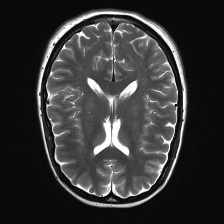

-1

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(x_train[0])

cv2.waitKey(0)


In [ ]:
n=450

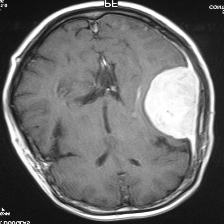

In [ ]:
from google.colab.patches import cv2_imshow


cv2_imshow(x_brain_seg[n])

cv2.waitKey(0)
print()

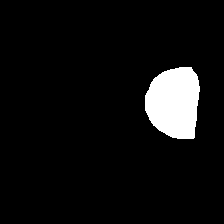

In [ ]:
from google.colab.patches import cv2_imshow


cv2_imshow(train_brain_mask[n]*255)

cv2.waitKey(0)
print()

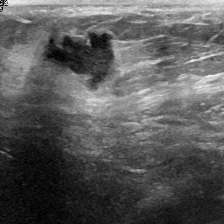

In [ ]:
from google.colab.patches import cv2_imshow


cv2_imshow(x_breast_seg[450])

cv2.waitKey(0)
print()

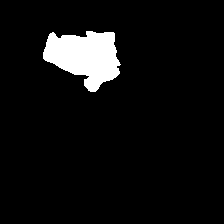

In [ ]:
from google.colab.patches import cv2_imshow


cv2_imshow(train_breast_mask[450]*255)

cv2.waitKey(0)

print()

# First Level Classification

## Best Model - ResNet50

In [ ]:
# Model - ResNet50
from keras.applications import ResNet50
from keras import layers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

base_Neural_Net= ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet', include_top=False)
model=Sequential()

model.add(base_Neural_Net)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
)

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max'
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)



94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

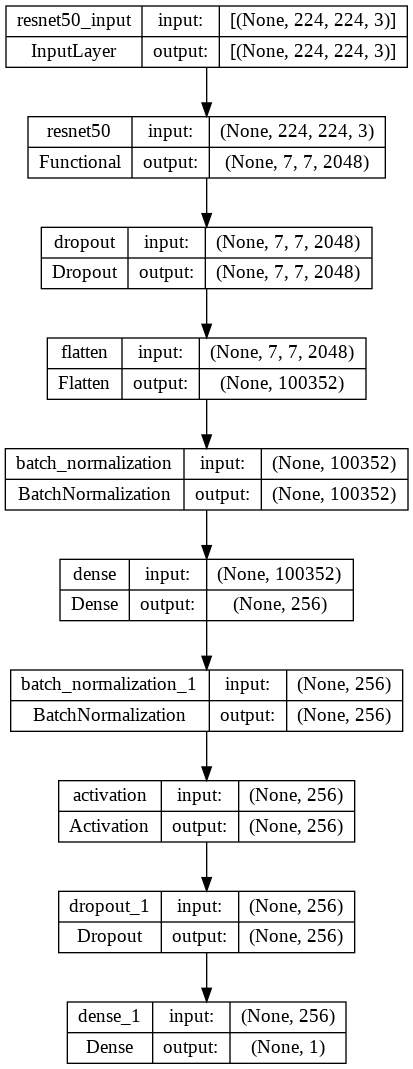

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:


start = dt.now()
history = model.fit(
    X, Y1,
    steps_per_epoch=50,
    epochs=30,
    validation_split=0.2,verbose=1,callbacks=[reduce_lr]
)
running_secs = (dt.now() - start).seconds
score = model.evaluate(x_test, Ys1_test, verbose=1)



Epoch 1/30
50/50 [==============================] - 261s 5s/step - loss: 0.0273 - accuracy: 0.9874 - recall: 0.9891 - precision: 0.9801 - val_loss: 1.6645e-06 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - lr: 0.0010
Epoch 2/30
50/50 [==============================] - 253s 5s/step - loss: 5.7872e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.7231e-05 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - lr: 0.0010
Epoch 3/30
50/50 [==============================] - 253s 5s/step - loss: 9.5158e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 4.3346e-05 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - lr: 0.0010
Epoch 4/30
50/50 [==============================] - 252s 5s/step - loss: 3.2425e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - val_loss: 4.8769e-05 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - lr: 0.0010
Epoch 5/30
50/50 [==========

In [ ]:
#@title Training Time
print(str(datetime.timedelta(seconds=running_secs)))

In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall']),max(history.history['val_recall'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Test Perfomance
pf=[[score[0],score[1],score[2],score[3]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','Test accuracy','Recall','Precision']
performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
Ys1_pred=model.predict(x_test)
y_pred = Ys1_pred>0.5
y_pred = y_pred.astype(int)
cf_matrix = confusion_matrix(y_pred, Ys1_test)
sns.heatmap(cf_matrix, annot=True,fmt="d",cmap='Blues')

In [ ]:
#@title Visualization of some performance metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Inecption V3

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)


x = base_model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

#x = preprocess_input(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

#print(decode_predictions(predictions, top=5)) 

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [ ]:
model.summary()

In [ ]:
# train 
start = dt.now()
history=model.fit(X, Y1, batch_size=32, epochs=15, validation_split=0.2,verbose=1)
start = dt.now()
# test
score = model.evaluate(x_test, Ys1_test, verbose=1)


In [ ]:
#@title Training Time
print(str(datetime.timedelta(seconds=running_secs)))

In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall_1']),max(history.history['val_recall_1'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Test Perfomance
print(f'Test loss: {score[0]} \nTest accuracy: {score[1]}\nRecall: {score[2]}\nPrecision: {score[3]}')
pf=[[score[0],score[1],score[2],score[3]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','Test accuracy','Recall','Precision']


In [ ]:
Ys1_pred=model.predict(x_test)
y_pred = Ys1_pred>0.5
y_pred = y_pred.astype(int)
cf_matrix = confusion_matrix(y_pred, Ys1_test)
sns.heatmap(cf_matrix, annot=True,fmt="d",cmap='Blues')

# Brain Classification Tumor / No Tumor
    

In [ ]:
X_Brain_Train,Y_Brain_Train=shuffle(X_Brain_Train,Y_Brain_Train, random_state=0)

In [ ]:
# Model - ResNet50
from keras.applications import ResNet50
from keras import layers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

base_Neural_Net= ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet', include_top=False)
model=Sequential()

model.add(base_Neural_Net)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
)

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max'
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)



In [ ]:
model.summary()


In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
start = dt.now()
history = model.fit(
    X_Brain_Train, Y_Brain_Train,
    steps_per_epoch=50,
    epochs=30,
    validation_split=0.2,verbose=1,callbacks=[reduce_lr]
)
running_secs = (dt.now() - start).seconds

score = model.evaluate(X_Brain_Test, Y_Brain_Test, verbose=1)

In [ ]:
#@title Training Time
print(str(datetime.timedelta(seconds=running_secs)))

In [ ]:
model.save('Brain_class.h5')
model1 = load_model('Brain_class.h5')

In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall_2']),max(history.history['val_recall_2'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Test Perfomance
print(f'Test loss: {score[0]} \nTest accuracy: {score[1]}\nRecall: {score[2]}\nPrecision: {score[3]}')
pf=[[score[0],score[1],score[2],score[3]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','Test accuracy','Recall','Precision']
performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
YB = model.predict(X_Brain_Test)
y_pred_brain = YB>0.5
y_pred_brain = y_pred_brain.astype(int)

In [ ]:
cf_matrix = confusion_matrix(y_pred_brain, Y_Brain_Test)
sns.heatmap(cf_matrix, annot=True,fmt="d",cmap='Blues')

In [ ]:
#@title Visualization of some performance metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Breast Classification


In [ ]:
Y_Breast_Train=encode(Y_Breast_Train)


In [ ]:
X_Breast_Train,Y_Breast_Train=shuffle(X_Breast_Train,Y_Breast_Train, random_state=0)

In [ ]:
Y_Breast_Test=np.asarray(Y_Breast_Test)
Y_Breast_Test=encode(Y_Breast_Test)

In [ ]:
## checking for imbalance
print("Breast - Normal: ",len(normal_train))
print("Breast - Benign: ",len(benign_train))
print("Breast - Malignant: ",len(malignant_train))

### High Imbalance in breast data -> Trying upsampling

In [ ]:
from sklearn.utils import resample
normal_train = resample(normal_train, 
                                 replace=True,   
                                 n_samples=397)
malignant_train = resample(malignant_train,
                                 replace=True,     
                                 n_samples=397)

In [ ]:
## after upsampling
print("Breast - Normal: ",len(normal_train))
print("Breast - Benign: ",len(benign_train))
print("Breast - Malignant: ",len(malignant_train))

In [ ]:
normal_Y = (np.concatenate(((np.ones((397,1))),np.zeros((397,1))),axis=1)).astype(int)
benign_Y = (np.concatenate(((np.ones((397,1))),np.ones((397,1))),axis=1)).astype(int)
malignant_Y = (np.concatenate(((np.ones((397,1))),(np.full((397, 1), 2, dtype=int))),axis=1)).astype(int)

In [ ]:
benign_Y=np.asarray(benign_Y)

In [ ]:
classification_breast_X = np.concatenate((np.array(normal_train),np.array(benign_train),np.array(malignant_train)),axis=0)
classification_breast_Y = np.concatenate((np.array(normal_Y[:,1]),np.array(benign_Y[:,1]),np.array(malignant_Y[:,1])),axis=0)

In [ ]:

classification_breast_Y=encode(classification_breast_Y)
classification_breast_X,classification_breast_Y=shuffle(classification_breast_X,classification_breast_Y, random_state=42)
classification_breast_Y.shape


In [ ]:
Y_Breast_Test.shape

# BREAST CLASSIFICATION - Trying different Architectures 

##ResNet50

In [ ]:

from keras.applications import ResNet50
from keras import layers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

base_Neural_Net= ResNet50(input_shape=(IMG_SIZE,IMG_SIZE,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

for layer in base_Neural_Net.layers:
    layer.trainable = False

    
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',

    metrics=['accuracy' , tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
)


es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max'
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.00001)
history = model.fit(
    X_Breast_Train, Y_Breast_Train,
    steps_per_epoch=50,
    epochs=30,
    validation_split=0.1,verbose=1,
callbacks=[reduce_lr])
model.summary()
score = model.evaluate(X_Breast_Test, Y_Breast_Test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}, Recall: {score[2]}, Precision: {score[3]}')



In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall_3']),max(history.history['val_recall_3'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Testing
score = model.evaluate(X_Breast_Test, Y_Breast_Test, verbose=1)
print(f'Test loss: {score[0]}\nTest accuracy: {score[1]}\nRecall: {score[2]}\nPrecision: {score[3]}')

##ResNet152V2

In [ ]:

model=tf.keras.applications.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE,IMG_SIZE,3),
    pooling=None,
    classes=3,
    classifier_activation="softmax",
)
model=Sequential()
model.add(base_Neural_Net)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy' , tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]
)




history = model.fit(
    X_Breast_Train, Y_Breast_Train,
    steps_per_epoch=50,
    epochs=30,
    validation_split=0.1,verbose=1,callbacks=[reduce_lr])

score = model.evaluate(X_Breast_Test, Y_Breast_Test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}, Recall: {score[2]}, Precision: {score[3]}')


In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall_4']),max(history.history['val_recall_4'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Testing
score = model.evaluate(X_Breast_Test, Y_Breast_Test, verbose=1)
print(f'Test loss: {score[0]}\nTest accuracy: {score[1]}\nRecall: {score[2]}\nPrecision: {score[3]}')

##DenseNet

In [ ]:

## evaluate

pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = True

x1 = pretrained_densenet.output
x1 = tf.keras.layers.Dropout(0.2, name="dropout_head_1")(x1)
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.2, name="dropout_head_2")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy' , tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.0000001)

history=model_densenet.fit(X_Breast_Train, Y_Breast_Train,epochs=80,validation_split=0.05,verbose=1,callbacks=[reduce_lr])


In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall_5']),max(history.history['val_recall_5'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Testing
score = model_densenet.evaluate(X_Breast_Test, Y_Breast_Test, verbose=1)
print(f'Test loss: {score[0]}\nTest accuracy: {score[1]}\nRecall: {score[2]}\nPrecision: {score[3]}')

#BEST MODEL FOR BREAST CLASS. - MobileNet

## Using Upsampled Data

In [ ]:

from keras.applications import MobileNet
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy' , tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])





In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
start = dt.now()
history=model.fit(classification_breast_X, classification_breast_Y,epochs=40,validation_split=0.05,verbose=1,callbacks=[reduce_lr])
running_secs = (dt.now() - start).seconds
score = model.evaluate(X_Breast_Test, Y_Breast_Test, verbose=1)

In [ ]:
#@title Training Time
print(str(datetime.timedelta(seconds=running_secs)))

In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall_6']),max(history.history['val_recall_6'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Test Perfomance
pf=[[score[0],score[1],score[2],score[3]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','Test accuracy','Recall','Precision']
performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
YBT = np.argmax(Y_Breast_Test,axis=1)


In [ ]:
YB = model.predict(X_Breast_Test)
YPB=np.argmax(YB,axis=1)
cf_matrix = confusion_matrix(YPB, YBT)
sns.heatmap(cf_matrix, annot=True,fmt="d",cmap='Blues')

In [ ]:
#@title Visualization of some performance metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Without Upsampling

In [ ]:
from keras.applications import MobileNet
base_model=MobileNet(input_shape=(IMG_SIZE,IMG_SIZE,3),weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy' , tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.0000001)


In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
start = dt.now()
history=model.fit(X_Breast_Train, Y_Breast_Train,epochs=40,validation_split=0.05,verbose=1,callbacks=[reduce_lr])
running_secs = (dt.now() - start).seconds
score = model.evaluate(X_Breast_Test, Y_Breast_Test, verbose=1)

In [ ]:
#@title Model Performance 

pf=[[min(history.history['loss']),min(history.history['val_loss']),max(history.history['accuracy']),max(history.history['val_accuracy']),max(history.history['recall_7']),max(history.history['val_recall_7'])]]
performance = pd.DataFrame(pf)
performance.columns=['Minimum training loss','Minimum Val. Loss','Maximum training accuracy','Maximum val. accuracy','Max training recall','Max val. recall']

performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Test Perfomance
print(f'Test loss: {score[0]} \nTest accuracy: {score[1]}\nRecall: {score[2]}\nPrecision: {score[3]}')
pf=[[score[0],score[1],score[2],score[3]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','Test accuracy','Recall','Precision']
performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
YBT = np.argmax(Y_Breast_Test,axis=1)

In [ ]:
YB = model.predict(X_Breast_Test)

YPB=np.argmax(YB,axis=1)
cf_matrix = confusion_matrix(YPB, YBT)
sns.heatmap(cf_matrix, annot=True,fmt="d",cmap='Blues')

In [ ]:
#@title Visualization of some performance metrics
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#SEGMENTATION

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
y_brain_tumor=np.asarray(Ytrain_brain)
y_brain_tumor=y_brain_tumor[:,1]


In [ ]:
x_brain_seg=np.asarray(x_brain_seg)
train_brain_mask=np.asarray(train_brain_mask)
x_brain_seg,train_brain_mask  = shuffle(x_brain_seg,train_brain_mask, random_state=0)

In [ ]:
x_brain_seg_test=np.asarray(x_brain_seg_test)

In [ ]:
x_brain_seg=x_brain_seg/255
x_brain_seg_test=x_brain_seg_test/255

In [ ]:
x_breast_seg_test=np.asarray(x_breast_seg_test)
train_brain_mask=np.asarray(train_brain_mask)

In [ ]:
train_brain_mask=train_brain_mask.reshape(-1,IMG_SIZE,IMG_SIZE,1)

In [ ]:
x_breast_seg_test=np.asarray(x_breast_seg_test)

In [ ]:
x_brain_seg.shape

In [ ]:
test_brain_mask=np.array(test_brain_mask)


In [ ]:
!pip install segmentation_models

## Pretrained Unet + ResNet34

In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data

# preprocess input
x_brain_seg = preprocess_input(x_brain_seg)

#x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, input_shape=(224, 224, 3),encoder_weights='imagenet',classes=1, activation='sigmoid')
model.compile(
    'Adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3),dice_coef],
)




In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
start = dt.now()
history=model.fit(tf.expand_dims(x_brain_seg, axis=-1),train_brain_mask,validation_split=0.1,batch_size=16,epochs=50)
running_secs = (dt.now() - start).seconds
score = model.evaluate(x_brain_seg_test, test_brain_mask, verbose=1)

In [ ]:
#@title Training Time
print(str(datetime.timedelta(seconds=running_secs)))

In [ ]:
model.save('Brain_seggg.h5')
model1 = load_model('Brain_seggg.h5',custom_objects={'dice_coef':dice_coef})

In [ ]:
#@title Model Performance 

pf=[[max(history.history['loss']),max(history.history['val_loss']),max(history.history['binary_io_u']),max(history.history['val_binary_io_u']),max(history.history['dice_coef']),max(history.history['val_dice_coef'])]]
performance = pd.DataFrame(pf)
performance.columns=['Max. training loss','Minimum Val. Loss','Maximum training IoU','Maximum val. accuracy','Max Dice coef','Max Dice coef']

performance

In [ ]:
#@title Test Perfomance

pf= [[score[0],score[1],score[2]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','IoU','Dice Coef']
performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
#@title Visualization of some performance metrics
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['binary_io_u'])
plt.plot(history.history['val_binary_io_u'])
plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
## Display a random output from test data
n=66
output=model.predict(x_brain_seg_test)
output_=binarize_mask(output[n]*255)
print('\nImage\n')

cv2_imshow(x_brain_seg_test[n]*255)

cv2.waitKey(0)
x_breast_seg_test
print("\nReal Mask\n")


cv2_imshow(test_brain_mask[n]*255)

cv2.waitKey(0)

print('\nwidth:', sum((test_brain_mask[n]> 0).any(axis=0)))
print('height:', sum((test_brain_mask[n]> 0).any(axis=1)))

print("\n\nPredicted Mask\n")
cv2_imshow(output_*255)

cv2.waitKey(0)

print('\nwidth:', sum((output_> 0).any(axis=0)))
print('height:', sum((output_> 0).any(axis=1)))

#BREAST SEGMENTATION

In [ ]:
x_breast_seg=np.asarray(x_breast_seg)
train_breast_mask=np.asarray(train_breast_mask)

In [ ]:
x_breast_seg_test=np.asarray(x_breast_seg_test)
test_breast_mask=np.asarray(test_breast_mask)

In [ ]:
x_breast_seg=x_breast_seg/255
x_breast_seg_test=x_breast_seg_test/255

In [ ]:
x_breast_seg,train_breast_mask=shuffle(x_breast_seg,train_breast_mask,random_state=42)


## Pretrained UNet + EfficientNetB2

In [ ]:
import segmentation_models as sm

BACKBONE = 'efficientnetb2'  
preprocess_input = sm.get_preprocessing(BACKBONE)



# preprocess input
X_Breast_Train = preprocess_input(X_Breast_Train)


# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet',classes=1, activation='sigmoid')
model.compile(
    'Adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3),dice_coef],
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=3, min_lr=0.0000001)
train_breast_mask=tf.cast(train_breast_mask, tf.float32)


In [ ]:
model.summary()

In [ ]:
# fit model
start = dt.now()
history=model.fit(
   x_breast_seg,
   train_breast_mask,
   batch_size=16,
   epochs=45,
   validation_split=0.1,
   verbose=1,callbacks=[reduce_lr])
running_secs = (dt.now() - start).seconds
score = model.evaluate(x_breast_seg_test, test_breast_mask, verbose=1)

In [ ]:
#@title Training Time
print(str(datetime.timedelta(seconds=running_secs)))

In [ ]:
model.save('Breast_seg.h5')
model1 = load_model('Breast_seg.h5',custom_objects={'dice_coef':dice_coef})

In [ ]:
#@title Model Performance 

pf=[[max(history.history['loss']),max(history.history['val_loss']),max(history.history['binary_io_u_1']),max(history.history['val_binary_io_u_1']),max(history.history['dice_coef']),max(history.history['val_dice_coef'])]]
performance = pd.DataFrame(pf)
performance.columns=['Max. training loss','Minimum Val. Loss','Maximum training IoU','Maximum val. accuracy','Max Dice coef','Max Dice coef']

performance

In [ ]:
#@title Visualization of some performance metrics
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['binary_io_u_1'])
plt.plot(history.history['val_binary_io_u_1'])
plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#@title Test Perfomance

pf= [[score[0],score[1],score[2]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','IoU','Dice Coef']
performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

## Pretrained UNet + MobileNet

In [ ]:
import segmentation_models as sm

BACKBONE = 'mobilenet'
preprocess_input = sm.get_preprocessing(BACKBONE)



# preprocess input
X_Breast_Train = preprocess_input(X_Breast_Train)


# define model
model = sm.Unet(BACKBONE, input_shape=(IMG_SIZE, IMG_SIZE, 3),encoder_weights='imagenet',classes=1, activation='sigmoid')
model.compile(
    'Adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.3),dice_coef])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0000001)



In [ ]:
model.summary()

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# fit model
start = dt.now()
history=model.fit(x_breast_seg,train_breast_mask,batch_size=16,epochs=60,validation_split=0.1,verbose=1,callbacks=[reduce_lr])
running_secs = (dt.now() - start).seconds
score = model.evaluate(x_breast_seg_test, test_breast_mask, verbose=1)

In [ ]:
#@title Training Time
print(str(datetime.timedelta(seconds=running_secs)))

In [ ]:
model.save('Breast_mseg.h5')
model1 = load_model('Breast_mseg.h5',custom_objects={'dice_coef':dice_coef})

In [ ]:
#@title Model Performance 

pf=[[max(history.history['loss']),max(history.history['val_loss']),max(history.history['binary_io_u_2']),max(history.history['val_binary_io_u_2']),max(history.history['dice_coef']),max(history.history['val_dice_coef'])]]
performance = pd.DataFrame(pf)
performance.columns=['Max. training loss','Minimum Val. Loss','Maximum training IoU','Maximum val. accuracy','Max Dice coef','Max Dice coef']

performance

In [ ]:
#@title Visualization of some performance metrics
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['binary_io_u_2'])
plt.plot(history.history['val_binary_io_u_2'])
plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#@title Test Perfomance

pf= [[score[0],score[1],score[2]]]
performance = pd.DataFrame(pf)
performance.columns=['Test loss','IoU','Dice Coef']
performance = performance.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
performance.set_properties(**{'text-align': 'center'}).hide_index()

In [ ]:
## Display a random output from test data
n=10
output=model.predict(x_breast_seg_test)
output_=binarize_mask(output[n]*255)
print('\nImage\n')

cv2_imshow(x_breast_seg_test[n]*255)

cv2.waitKey(0)
x_breast_seg_test
print("\nReal Mask\n")


cv2_imshow(test_breast_mask[n]*255)

cv2.waitKey(0)

print('\nwidth:', sum((test_breast_mask[n]> 0).any(axis=0)))
print('height:', sum((test_breast_mask[n]> 0).any(axis=1)))

print("\n\nPredicted Mask\n")
cv2_imshow(output_*255)

cv2.waitKey(0)

print('\nwidth:', sum((output_> 0).any(axis=0)))
print('height:', sum((output_> 0).any(axis=1)))